# Project 3: Vision Transformers vs. Convolutional Neural Networks

Authors: Selim Ben Abdallah, Paola De Truchis, Eduardo De Jesus Zancanaro Garcia and Edda Iveland

The goal of this project is to compare the performance of vision transformers (ViTs) to convolutional neural networks (CNNs) on the task of image classification on labelled datasets. 

### Outline : 

---------

* 0 - Libraries, util functions and global variables
* 1 - Choice of datasets and Exploratory Data Analysis
* 2 - Convolutional Neural Network
* 3 - Vision Transformer
* 4 - Comparison of results
* 5 - Comparison to literatire

---------

## 0 -  Libraries, util functions and global variables

### Imports

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import json
import pandas as pd
import random
from tqdm import tqdm

#to import cifar-10
import pickle

import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F

from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, roc_auc_score, classification_report, average_precision_score, precision_recall_curve

### Functions

#### Training and evaluating

In [2]:
def plot_train_val_loss(history):
    epochs = range(1, len(history["train_loss"]) + 1)

    plt.figure(figsize=(6, 6))
    plt.plot(epochs, history["train_loss"], label="Train Loss")
    plt.plot(epochs, history["val_loss"], label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss Curve")
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_accuracy(history):
    epochs = range(1, len(history["train_loss"]) + 1)

    plt.figure(figsize=(6, 6))
    plt.plot(epochs, history["train_acc"], label="Train Accuracy")
    plt.plot(epochs, history["val_acc"], label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [3]:
def classification_metrics_multiclass(y_true, y_prob, class_names=None):
    """
    Metrics for multiclass classification.

    Assumptions:
    - y_true are integer class labels in {0, 1, ..., n_classes-1}
    - y_prob has shape (N, C) with C = number of model classes,
      and columns correspond to class indices 0..C-1 in that order.
    """

    y_true = np.array(y_true)
    y_prob = np.array(y_prob)

    if y_prob.ndim != 2:
        raise ValueError(
            f"Expected y_prob to have shape (N, C) for multiclass, got shape {y_prob.shape}"
        )

    n_samples, n_classes = y_prob.shape

    # ---------- Class names ----------
    if class_names is None:
        class_names = [str(i) for i in range(n_classes)]
    else:
        assert len(class_names) == n_classes, \
            f"len(class_names)={len(class_names)} does not match n_classes={n_classes}"

    # ---------- Predictions ----------
    y_pred = np.argmax(y_prob, axis=1)

    # ---------- Confusion matrix & classification report ----------
    cm = confusion_matrix(y_true, y_pred)

    report = classification_report(
        y_true,
        y_pred,
        labels=np.arange(n_classes),   # force all classes 0..C-1
        target_names=class_names,
        digits=3,
        zero_division=0,
    )

    # ---------- Multiclass ROC AUC (macro, One-vs-Rest) ----------
    try:
        roc_auc_macro_ovr = roc_auc_score(
            y_true,
            y_prob,
            multi_class="ovr",
            average="macro",
            labels=np.arange(n_classes),
        )
    except ValueError:
        roc_auc_macro_ovr = None

    # ---------- Per-class PR curves & AP ----------
    precision = {}
    recall = {}
    pr_thresholds = {}
    ap_per_class = {}

    # y_true one-hot
    y_true_bin = np.eye(n_classes)[y_true]  # shape (N, n_classes)

    for i, cname in enumerate(class_names):
        precision[cname], recall[cname], pr_thresholds[cname] = precision_recall_curve(
            y_true_bin[:, i], y_prob[:, i]
        )
        ap_per_class[cname] = average_precision_score(
            y_true_bin[:, i], y_prob[:, i]
        )

    # Macro-average AP
    average_precision_macro = float(np.mean(list(ap_per_class.values())))

    # For compatibility with save_model_and_results:
    # - "roc_auc" will be the macro OVR ROC AUC
    # - "average_precision" will be the per-class AP dict
    return {
        "confusion_matrix": cm,
        "classification_report": report,
        "roc_auc_macro_ovr": roc_auc_macro_ovr,
        "precision": precision,
        "recall": recall,
        "pr_thresholds": pr_thresholds,
        "average_precision_per_class": ap_per_class,
        "average_precision_macro": average_precision_macro,
        # keys expected by save_model_and_results
        "roc_auc": roc_auc_macro_ovr,
        "average_precision": ap_per_class,
    }



def plot_confusion_matrix(cm, class_names, title="Confusion Matrix"):
    plt.figure(figsize=(12,12))
    sns.heatmap(
        cm,
        annot=False,
        #fmt="d",
        cmap="Blues",
        xticklabels=class_names,
        yticklabels=class_names
    )
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.tight_layout()
    plt.show()

In [4]:
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for imgs, labels in tqdm(loader, desc="Training", leave=False):
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * imgs.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    return total_loss / total, correct / total

def evaluate_multiclass(model, loader, criterion, device):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for imgs, labels in tqdm(loader, desc="Validating", leave=False):
            imgs, labels = imgs.to(device), labels.to(device)

            outputs = model(imgs)
            loss = criterion(outputs, labels)

            total_loss += loss.item() * imgs.size(0)

            # MULTICLASS: keep ALL class probabilities
            probs = F.softmax(outputs, dim=1)   # shape [B, num_classes]
            preds = outputs.argmax(dim=1)

            correct += (preds == labels).sum().item()
            total += labels.size(0)

            all_labels.append(labels.cpu().numpy())
            all_probs.append(probs.cpu().numpy())

    avg_loss = total_loss / total
    acc = correct / total

    all_labels = np.concatenate(all_labels)     # shape [N]
    all_probs = np.concatenate(all_probs)       # shape [N, num_classes]

    return avg_loss, acc, all_labels, all_probs

In [5]:

def show_random_classif_predictions(model, dataset, device, class_names, num_images=9):
    model.eval()

    indices = random.sample(range(len(dataset)), num_images)

    # Adapt grid size for visualization (e.g., square root)
    grid_size = int(num_images ** 0.5)
    plt.figure(figsize=(grid_size * 4, grid_size * 4))

    for i, idx in enumerate(indices):
        img, label, filename = dataset[idx]
        img_tensor = img.unsqueeze(0).to(device)

        with torch.no_grad():
            logits = model(img_tensor)
            probs = F.softmax(logits, dim=1)[0]  # shape: [num_classes]
            pred = torch.argmax(probs).item()

        img_vis = denormalize_image(img)

        plt.subplot(grid_size, grid_size, i + 1)
        plt.imshow(img_vis)
        plt.axis("off")

        # Compose prediction probabilities string for all classes
        prob_str = ", ".join([f"P_{name}={probs[j]:.2f}" for j, name in enumerate(class_names)])

        pred_name = class_names[pred]
        true_name = class_names[label]

        title = (
            f"{filename}\n"
            f"Pred: {pred_name}\n"
            f"{prob_str}\n"
            f"True: {true_name}"
        )

        plt.title(title, fontsize=10)

    plt.tight_layout()
    plt.show()


In [6]:
def predict_image(model, img_path, transform, device="cpu"):
    model.eval()
    img = Image.open(img_path).convert("RGB")
    tensor = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        logits = model(tensor)
        pred = logits.argmax(dim=1).item()

    return pred, img

In [7]:
def study_most_confused_classes(cm, label_map, top_k=10):

    # Normalize rows 
    cm_normalized = cm.astype(float) / cm.sum(axis=1, keepdims=True)

    pairs = []
    num_classes = len(cm_normalized)

    for i in range(num_classes):
        for j in range(num_classes):
            if i != j:
                true_label = label_map[i] if not isinstance(label_map, dict) else label_map[i]
                pred_label = label_map[j] if not isinstance(label_map, dict) else label_map[j]
                pairs.append((true_label, pred_label, cm_normalized[i, j]))

    # Sorts confusion
    confusion_pairs = sorted(pairs, key=lambda x: x[2], reverse=True)

    # Print of most confused pairs
    print(f"\nTop {top_k} most confused class pairs:")
    for true_label, pred_label, rate in confusion_pairs[:top_k]:
        print(f"{true_label} → {pred_label}: {rate:.2f}")

    return confusion_pairs

In [8]:
def plot_misclassified_pair(
    model,
    samples,
    true_label_idx,
    pred_label_idx,
    label_map,
    transform,
    device,
    n_samples=5,
    label_col="breed_idx",   # <-- default: your multiclass label column
    path_col="img_path",     # <-- in case this differs too
):
    model.eval()
    misclassified = []

    for _, row in samples.iterrows():
        img_path = row[path_col]
        pred_idx, img = predict_image(model, img_path, transform, device)
        true_idx = row[label_col]

        if true_idx == true_label_idx and pred_idx == pred_label_idx:
            misclassified.append((img, true_idx, pred_idx))

    if len(misclassified) == 0:
        print("No misclassified samples found for this pair.")
        return

    examples = random.sample(misclassified, min(n_samples, len(misclassified)))

    n_cols = len(examples)
    plt.figure(figsize=(4 * n_cols, 4))
    for i, (img, true_idx, pred_idx) in enumerate(examples):
        plt.subplot(1, n_cols, i + 1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"True: {label_map[true_idx]}\nPred: {label_map[pred_idx]}")
    plt.show()

#### Save and load

In [9]:
os.makedirs("models", exist_ok=True)

In [10]:
def save_model_and_results(
    save_dir: str,
    model: torch.nn.Module,
    history: dict,
    y_true: np.ndarray,
    y_prob: np.ndarray,
    metrics: dict,
    model_filename: str = "model_weights.pth",
):
    # Create the full directory path you passed
    os.makedirs(save_dir, exist_ok=True)

    # --- Save model weights ---
    model_path = os.path.join(save_dir, model_filename)
    torch.save(model.state_dict(), model_path)

    # --- Save training history ---
    pd.DataFrame(history).to_csv(
        os.path.join(save_dir, "training_history.csv"),
        index=False
    )

    # --- Save prediction arrays ---
    np.save(os.path.join(save_dir, "y_true.npy"), y_true)
    np.save(os.path.join(save_dir, "y_prob.npy"), y_prob)

    # --- Save confusion matrix ---
    np.save(
        os.path.join(save_dir, "confusion_matrix.npy"),
        metrics["confusion_matrix"]
    )

    # --- Save metrics.json ---
    avg_prec = metrics["average_precision"]
    if isinstance(avg_prec, dict):
        # multiclass: already per-class, JSON-serializable
        avg_prec_json = avg_prec
    else:
        # binary: single float
        avg_prec_json = float(avg_prec)

    metrics_for_json = {
        "roc_auc": float(metrics["roc_auc"]),
        "classification_report": metrics["classification_report"],
        "average_precision": avg_prec_json,
    }

    with open(os.path.join(save_dir, "metrics.json"), "w") as f:
        json.dump(metrics_for_json, f, indent=4)

    print(f"\nModel and results saved to: {save_dir}")


In [11]:
def load_model_and_results(
    save_dir: str,
    model: torch.nn.Module,
    device: str,
    model_filename: str = "model_weights.pth",
):
    # --- Load model ---
    model_path = os.path.join(save_dir, model_filename)
    state_dict = torch.load(model_path, map_location=device)
    model.load_state_dict(state_dict)
    model.eval()

    # --- Load history ---
    history_df = pd.read_csv(os.path.join(save_dir, "training_history.csv"))

    # --- Load predictions ---
    y_true = np.load(os.path.join(save_dir, "y_true.npy"))
    y_prob = np.load(os.path.join(save_dir, "y_prob.npy"))

    # --- Load confusion matrix ---
    cm = np.load(os.path.join(save_dir, "confusion_matrix.npy"))

    # --- Load metrics.json ---
    with open(os.path.join(save_dir, "metrics.json"), "r") as f:
        metrics_json = json.load(f)

    return model, history_df, y_true, y_prob, cm, metrics_json

## 1 - Choice of datasets

### CIFAR -10

The CIFAR-10 dataset contains 60000 labelled images of 10 classes: airplane, automobile, bird, cat, deer, dog, frog, horse, ship and truck. The images are coloured and of size 32x32, so the **images are not too big**. This makes training processes quicker. As the dataset is neither too big nor too small, we hope that differences in performance between CNNs and ViTs will not be due to the dataset scale, but rather the models themselves. 

We will we defining the ViT and CNN **from scratch**, so using a dataset that is easier to train from scratch is essential. If we were to use a dataset with larger images, pretrained weights would have yielded higher performance, making it harder to compare models from scratch. 

Each class in the CIFAR-10 dataset contains the **same number of images** and labels are clear and distinguished. Consequently, differences between CNNs and ViTs will not be due to class imbalances or noisy annotations. 

Additionally, CIFAR-10 has been **extensively studied**, aiding the comparison we will perform at the end of this project to the literature. 

In [12]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [13]:
cifar_data_dir = "cifar-10-batches-py"

X_train = []
y_train = []

for i in range(1, 6):
    batch = unpickle(os.path.join(cifar_data_dir, f"data_batch_{i}"))
    X_train.append(batch[b'data'])
    y_train.append(batch[b'labels'])

X_train = np.concatenate(X_train)
y_train = np.concatenate(y_train)


test_batch = unpickle(os.path.join(cifar_data_dir, "test_batch"))

cifar_X_test = test_batch[b'data']
cifar_y_test = np.array(test_batch[b'labels'])

#make validation set
cifar_X_train, cifar_X_val, cifar_y_train, cifar_y_val = train_test_split(
    X_train,
    y_train,
    test_size=0.2,  # 1000 images for validation
    random_state=42,     
    stratify=y_train  # preserves class distribution
)

FileNotFoundError: [Errno 2] No such file or directory: 'cifar-10-batches-py/data_batch_1'

In [33]:
meta = unpickle(os.path.join(cifar_data_dir, "batches.meta"))
cifar_class_names = meta[b'label_names']
cifar_class_names = [name.decode("utf-8") for name in cifar_class_names]
cifar_num_classes = len(cifar_class_names)

print(cifar_class_names)
print("There are",cifar_num_classes, "classes")

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
There are 10 classes


In [34]:
print("There are", len(cifar_X_train), "images in the train set")
print("There are", len(cifar_X_val), "images in the validation set")
print("There are", len(cifar_X_test), "images in the test set")

There are 40000 images in the train set
There are 10000 images in the validation set
There are 10000 images in the test set


In [35]:
train_counts = np.bincount(cifar_y_train, minlength=cifar_num_classes)
val_counts   = np.bincount(cifar_y_val, minlength=cifar_num_classes)
test_counts  = np.bincount(cifar_y_test, minlength=cifar_num_classes)

In [36]:
def check_equal_counts(counts, split_name):
    if np.all(counts == counts[0]):
        print(f"{split_name}: each class has {counts[0]} images")
    else:
        print(f"{split_name}: class imbalance detected")
        print(counts)

check_equal_counts(train_counts, "Train")
check_equal_counts(val_counts, "Validation")
check_equal_counts(test_counts, "Test")

Train: each class has 4000 images
Validation: each class has 1000 images
Test: each class has 1000 images


There are the same amount of images for all 10 classes for the train, validation and test set. 

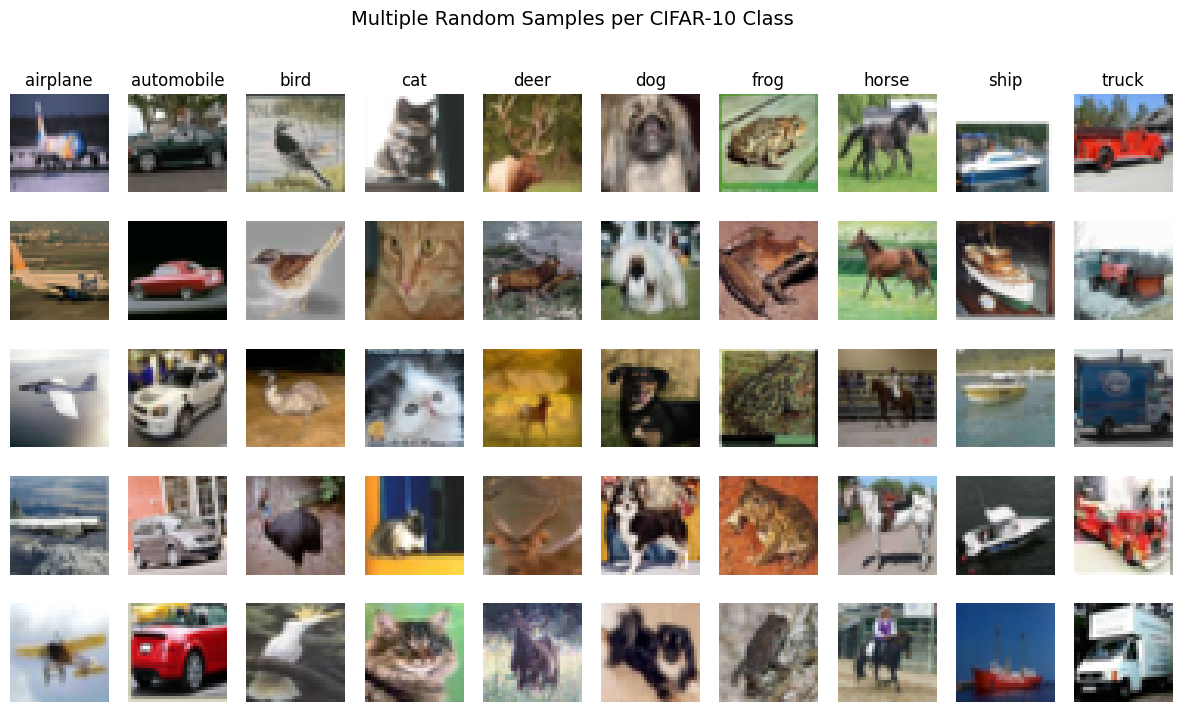

In [59]:
num_samples = 5
plt.figure(figsize=(15, 8))

for cls in range(cifar_num_classes):
    indices = np.where(cifar_y_train == cls)[0]
    chosen = np.random.choice(indices, num_samples, replace=False)

    for j, idx in enumerate(chosen):
        img = cifar_X_train[idx]
        if img.ndim == 1:
            img = img.reshape(3, 32, 32).transpose(1, 2, 0)

        plt.subplot(num_samples, cifar_num_classes, cls + j * cifar_num_classes + 1)
        plt.imshow(img)
        plt.axis("off")

        if j == 0:
            plt.title(cifar_class_names[cls])

plt.suptitle("Multiple Random Samples per CIFAR-10 Class", fontsize=14)
plt.show()

Exploratory data analysis: -- brightness, etc

In [ ]:
mean = (0.4914, 0.4822, 0.4465) # cifar-10 normaisation -> source? 
std  = (0.2470, 0.2435, 0.2616)

train_transform_cifar = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

train_transform_cifar_aug = transforms.Compose([
    transforms.ToPILImage(),
    # augmentation on training set 
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

val_test_transform_cifar = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

In [50]:
class CIFAR10Dataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        image = self.X[idx]          # shape: (3072,) (1024 per channel) or (3,32,32)
        label = self.y[idx]

        # reshape if still flattened
        if image.ndim == 1:
            image = image.reshape(3, 32, 32)

        image = torch.tensor(image, dtype=torch.float32)

        if self.transform:
            image = self.transform(image)

        label = torch.tensor(label, dtype=torch.long)
        return image, label

In [51]:
train_dataset_cifar = CIFAR10Dataset(cifar_X_train, cifar_y_train, transform=train_transform_cifar)
train_dataset_cifar_aug = CIFAR10Dataset(cifar_X_train, cifar_y_train, transform=train_transform_cifar_aug)
val_dataset_cifar = CIFAR10Dataset(cifar_X_val, cifar_y_val, transform=val_test_transform_cifar)
test_dataset_cifar = CIFAR10Dataset(cifar_X_test, cifar_y_test, transform=val_test_transform_cifar)

In [52]:
batch_size = 32 # 128
num_workers = 0 #4

In [53]:
train_loader_cifar= DataLoader(train_dataset_cifar, batch_size=batch_size, shuffle=True,  num_workers=num_workers)
train_loader_cifar_aug = DataLoader(train_dataset_cifar_aug, batch_size=batch_size, shuffle=True,  num_workers=num_workers)
val_loader_cifar   = DataLoader(val_dataset_cifar,   batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [55]:
images, labels = next(iter(train_loader_cifar))
print(images.shape)  # (Batch, 3, 32, 32)
print(labels.shape)  # (Batch,)

torch.Size([32, 3, 32, 32])
torch.Size([32])


### Dataset 2

## 2 - Convolutional Neural Network

### 2.1 - Vanilla CNN

inspiration: https://github.com/n-kostadinov/cnn-image-classification-cifar-10-from-scratch/blob/master/cnn-image-classification-cifar-10-from-scratch.ipynb

In [102]:
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()

        #convolutional layers
        self.conv1 =  nn.Conv2d(3, 32, kernel_size=3)
        self.conv2 =  nn.Conv2d(32, 64, kernel_size=3) 
        self.conv3 =  nn.Conv2d(64, 128, kernel_size=3)

        #maxpooling
        self.pool = nn.MaxPool2d(2, 2) 

        #flatten
        self.flatten = nn.Flatten()

        #dropout
        self.dropout = nn.Dropout(0.2)

        # fully connected layers
        self.fc1 = nn.Linear(2 * 2 * 128, 1024)
        self.fc2 = nn.Linear(1024, 128)
        self.fc3 = nn.Linear(128, num_classes)

    
    def forward(self, x):

        x = F.relu(self.conv1(x))  # Input: 32x32x3 - output : 30x30x32
        x = self.pool(x) # Output: 15x15x64
        x = F.relu(self.conv2(x)) # Output: 13x13x64
        x = self.pool(x) # Output: 6x6x64
        x = F.relu(self.conv3(x))  # Output: 4x4x128
        x = self.pool(x) # Output: 2x2x128

        x = self.flatten(x) # 2x2x128 = 512
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)  # Raw logits (softmax in loss)
        
        return x

In [103]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
model_CNN = CNN(num_classes=cifar_num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_CNN.parameters(), lr=1e-4, weight_decay=1e-4)

In [104]:
history_cnn_cifar = {
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": [],
}

for epoch in range(3):
    train_loss, train_acc = train_one_epoch(
        model_CNN,
        train_loader_cifar,
        optimizer, criterion, device
    )
    
    val_loss, val_acc, y_true, y_prob = evaluate_multiclass(
        model_CNN,
        val_loader_cifar,
        criterion, device
    )
    history_cnn_cifar["train_loss"].append(train_loss)
    history_cnn_cifar["train_acc"].append(train_acc)
    history_cnn_cifar["val_loss"].append(val_loss)
    history_cnn_cifar["val_acc"].append(val_acc)

    print(f"Epoch {epoch+1}: "
          f"Train Loss={train_loss:.4f}, Train Acc={train_acc:.3f} | "
          f"Val Loss={val_loss:.4f}, Val Acc={val_acc:.3f}")

# Final eval, after training
val_loss, val_acc, last_y_true, last_y_prob = evaluate_multiclass(
        model_CNN,
        val_loader_cifar,
        criterion, device
    )

y_true, y_prob = last_y_true, last_y_prob
metrics_cnn_cifar = classification_metrics_multiclass(y_true,y_prob,class_names=cifar_class_names)

Epoch 1: Train Loss=1.7774, Train Acc=0.341 | Val Loss=1.5543, Val Acc=0.430


Epoch 2: Train Loss=1.4858, Train Acc=0.459 | Val Loss=1.3944, Val Acc=0.496


Epoch 3: Train Loss=1.3532, Train Acc=0.510 | Val Loss=1.2703, Val Acc=0.541


##### Save model weights, training info

In [109]:
save_model_and_results(
    save_dir="models/cnn_cifar_noaug",
    model=model_CNN,
    history=history_cnn_cifar,
    y_true=y_true,
    y_prob=y_prob,
    metrics=metrics_cnn_cifar,
    model_filename="cnn_cifar_noaug.pth"
)


Model and results saved to: models/cnn_cifar_noaug



 -- Classification report --
              precision    recall  f1-score   support

    airplane      0.590     0.532     0.560      1000
  automobile      0.692     0.636     0.663      1000
        bird      0.373     0.525     0.436      1000
         cat      0.451     0.225     0.300      1000
        deer      0.475     0.329     0.389      1000
         dog      0.442     0.549     0.490      1000
        frog      0.573     0.675     0.620      1000
       horse      0.612     0.578     0.594      1000
        ship      0.652     0.704     0.677      1000
       truck      0.582     0.662     0.619      1000

    accuracy                          0.541     10000
   macro avg      0.544     0.541     0.535     10000
weighted avg      0.544     0.541     0.535     10000

ROC AUC: 0.9065923
AP (PR AUC): {'airplane': 0.621269936457815, 'automobile': 0.7243490200864635, 'bird': 0.4418012954262792, 'cat': 0.3840806995966988, 'deer': 0.46122984309548287, 'dog': 0.49905794125182185, '

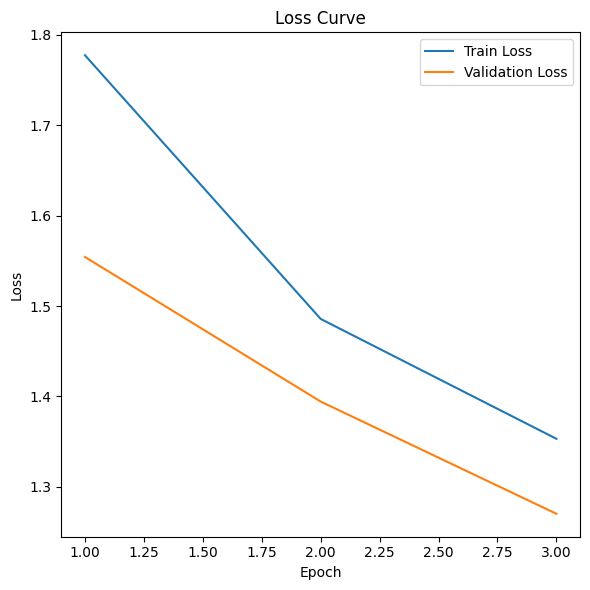

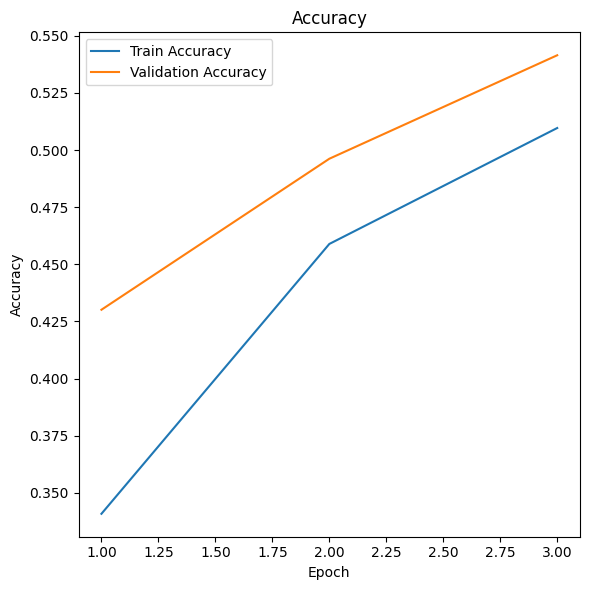

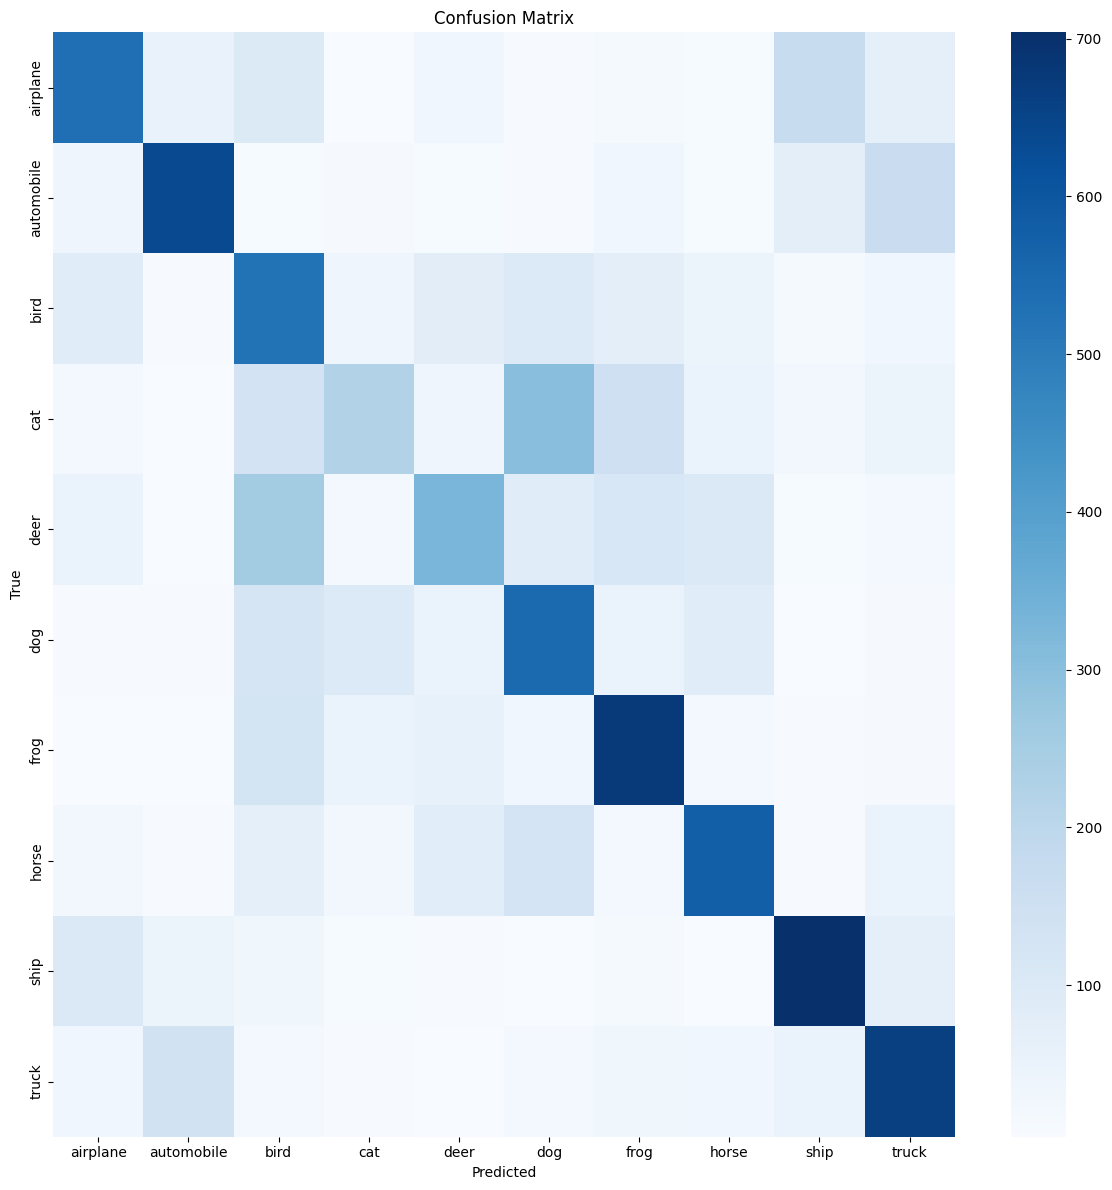

In [110]:
model_CNN_cifar, history_cnn_cifar, y_true_cifar, y_prob_cifar, cm_cifar, metrics_cnn_cifar = load_model_and_results(
    save_dir="models/cnn_cifar_noaug",
    model=model_CNN, 
    device=device,
    model_filename="cnn_cifar_noaug.pth",
)

print("\n -- Classification report --")
print(metrics_cnn_cifar["classification_report"])
print("ROC AUC:", metrics_cnn_cifar["roc_auc"])
print("AP (PR AUC):", metrics_cnn_cifar["average_precision"])

plot_train_val_loss(history_cnn_cifar)
plot_accuracy(history_cnn_cifar)
plot_confusion_matrix(cm_cifar, cifar_class_names)


roc_auc_macro_ovr = roc_auc_score(y_true_cifar, y_prob_cifar, multi_class="ovr", average="macro")
roc_auc_macro_ovo = roc_auc_score(y_true_cifar, y_prob_cifar, multi_class="ovo", average="macro")

### 2.2 - ResNet-18

### 2.3 - ConvNeXT (Tiny)

"ConvNeXT is a pure convolutional model (ConvNet), inspired by the design of Vision Transformers, that claims to outperform them." : https://huggingface.co/docs/transformers/model_doc/convnext

## 3 - Vision Transformer

### 3.1 - Vision Transformer (base version)

- Ressources :
- https://huggingface.co/google/vit-base-patch16-224 (pre-trained)
- An image is worth 16x16 words : Transformers for iamge recognition: https://arxiv.org/abs/2010.11929

### 3.2 - Swin Transformer

### 3.3 - Pyramid Vision Transformer

## 4 - Comparison of results

## 5 - Comparison to literature

- Blog post : Do ViT see like CNNs : https://towardsdatascience.com/do-vision-transformers-see-like-convolutional-neural-networks-paper-explained-91b4bd5185c8/
- An image is worth 16x16 words : Transformers for iamge recognition: https://arxiv.org/abs/2010.11929
- Nice video to understand to main concepts related to ViTs : https://www.youtube.com/watch?v=j3VNqtJUoz0

Citations: https://www.cs.toronto.edu/~kriz/learning-features-2009-TR.pdf
